In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import scipy.stats as st
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.multitest import fdrcorrection
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from sklearn.cross_decomposition import PLSRegression



In [2]:
df = pd.read_excel("CRC raw data for SUR analysis_ updated with patient ID.xlsx") # Read the dataset into DataFrame
df.head()

,Groups,Patient ID,1-Methyladenosine (282.1 / 150.0),1-Methylhistamine (126.0 / 109.0),2-Aminoadipate (160.1 / 116.0),2'-Deoxyuridine (229.1 / 113.0),3-Nitro-tyrosine (225.0 / 179.3),4-Pyridoxic acid (182.1 / 138.0),5-Hydroxytryptophan (221.0 / 134.0),Acetoacetate (101.0 / 57.0),...,Xanthurenate (204.0 / 160.0),Age at Consent,Gender,Smoking condition,Drink Alcohol?,Diagnosis,Stage,Height [cm],Weight [kg],BMI [kg/mÂ²]
0,C,157,363294.259462,17960.984799,211814.173332,13208.353198,58280.359867,377980.530580,92021.899523,105611.118157,...,59609.410280,67,M,Some days,Sometimes,Rectal cancer,Stage IV,185.42,83.01,24.14
1,C,200,258236.789778,42811.329275,129057.647700,12801.012511,52553.166613,394767.907583,83536.458311,36859.962030,...,144114.001359,27,M,Some days,Sometimes,Rectal cancer,Stage III,-,-,-
2,C,133,414501.111440,27448.734969,419826.633680,15743.580793,83879.056387,347876.887845,71699.642511,165972.978496,...,89328.496270,76,M,Non-smoker,At least 1 drink/day,Rectal cancer,Stage III,177.8,102.06,32.28
3,C,250,176265.809496,31305.118347,74719.594891,12988.760376,44804.979022,299757.728432,64873.586104,84477.481282,...,54699.598516,40,M,Some days,Sometimes,Rectal cancer,Stage III,-,-,-
4,C,109,390953.972475,34627.336453,141257.364048,13115.813117,92919.474825,333815.060513,68873.498069,46020.719642,...,92263.992784,45,M,Non-smoker,At least 1 drink/day,Rectal cancer,Stage I/II,187.96,95.25,26.96


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234 entries, 0 to 233
Columns: 124 entries, Groups to BMI [kg/mÂ²]
dtypes: float64(113), int64(2), object(9)
memory usage: 226.8+ KB


**Exploratory Principal Component Analysis (PCA): Minimal Separation Between CRC, Polyp, and Healthy Samples.**

---



*PCA revealed no strong separation between the CRC (C, red), polyp (P, green), and healthy (H, blue) groups. The first two principal components together accounted for approximately 22% of the total variance. Since PCA is an unsupervised method and does not use group labels, supervised methods such as PLS-DA that incorporate class information may provide better resolution of class-specific variation. Only a few potential outliers were observed, suggesting overall consistency across the samples.*





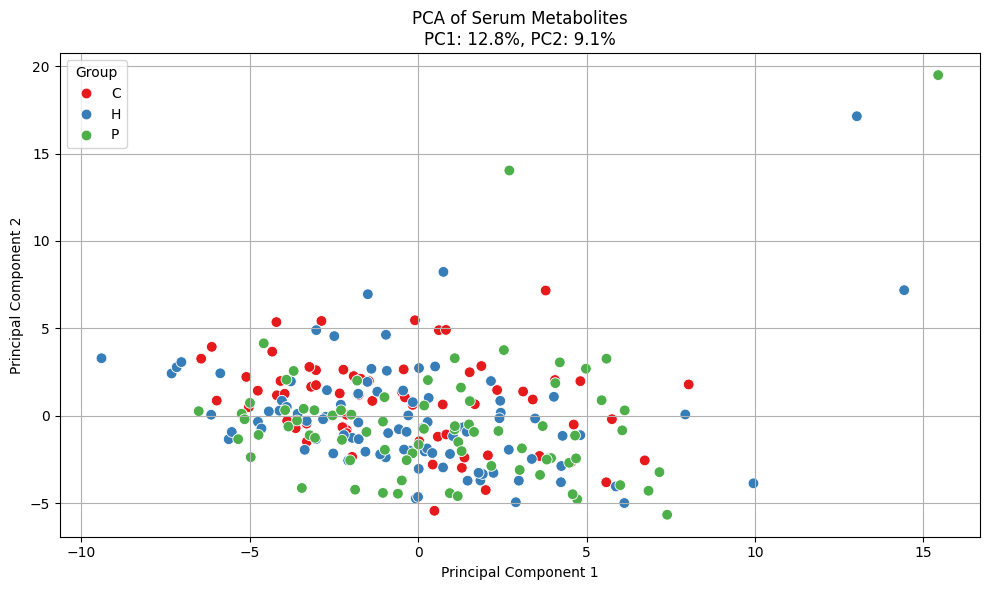

In [4]:
df_imputed = df.fillna(df.mean(numeric_only=True))  # Mean imputation for numeric columns

clinical_vars = ['Age at Consent', 'Height [cm]', 'Weight [kg]', 'BMI [kg/m²]']   # Clinical columns to exclude

metabolite_cols = [col for col in df_imputed.select_dtypes(include='number').columns if col not in clinical_vars] # Remove clinical vars from numeric columns

X_metabolites = df_imputed[metabolite_cols]

X_scaled = StandardScaler().fit_transform(X_metabolites) # Standardize


pca = PCA(n_components=2)   # 2D PCA

pca_result = pca.fit_transform(X_scaled)


labels = df_imputed['Groups']  # Labels (Groups column)


pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])  # Create DataFrame for plotting
pca_df['Group'] = labels


plt.figure(figsize=(10, 6)) # Plot
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Group', palette='Set1', s=60)
plt.title(f'PCA of Serum Metabolites\nPC1: {pca.explained_variance_ratio_[0]*100:.1f}%, PC2: {pca.explained_variance_ratio_[1]*100:.1f}%')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Group')
plt.grid(True)
plt.tight_layout()
plt.show()


**Improved Group Discrimination using Partial Least Square-Discriminant Analsysis (PLS-DA) Highlights CRC Uniqueness**

*PLS-DA demonstrated a clearer separation between CRC and the other groups, reinforcing that CRC samples possess a distinct metabolic profile. In contrast, polyp and healthy samples largely overlapped, indicating similar metabolic characteristics between these groups. Notably, a two-class PLS-DA comparing CRC and polyp samples exhibited slightly better discrimination than CRC versus healthy, further highlighting the unique metabolic signature of CRC!!*



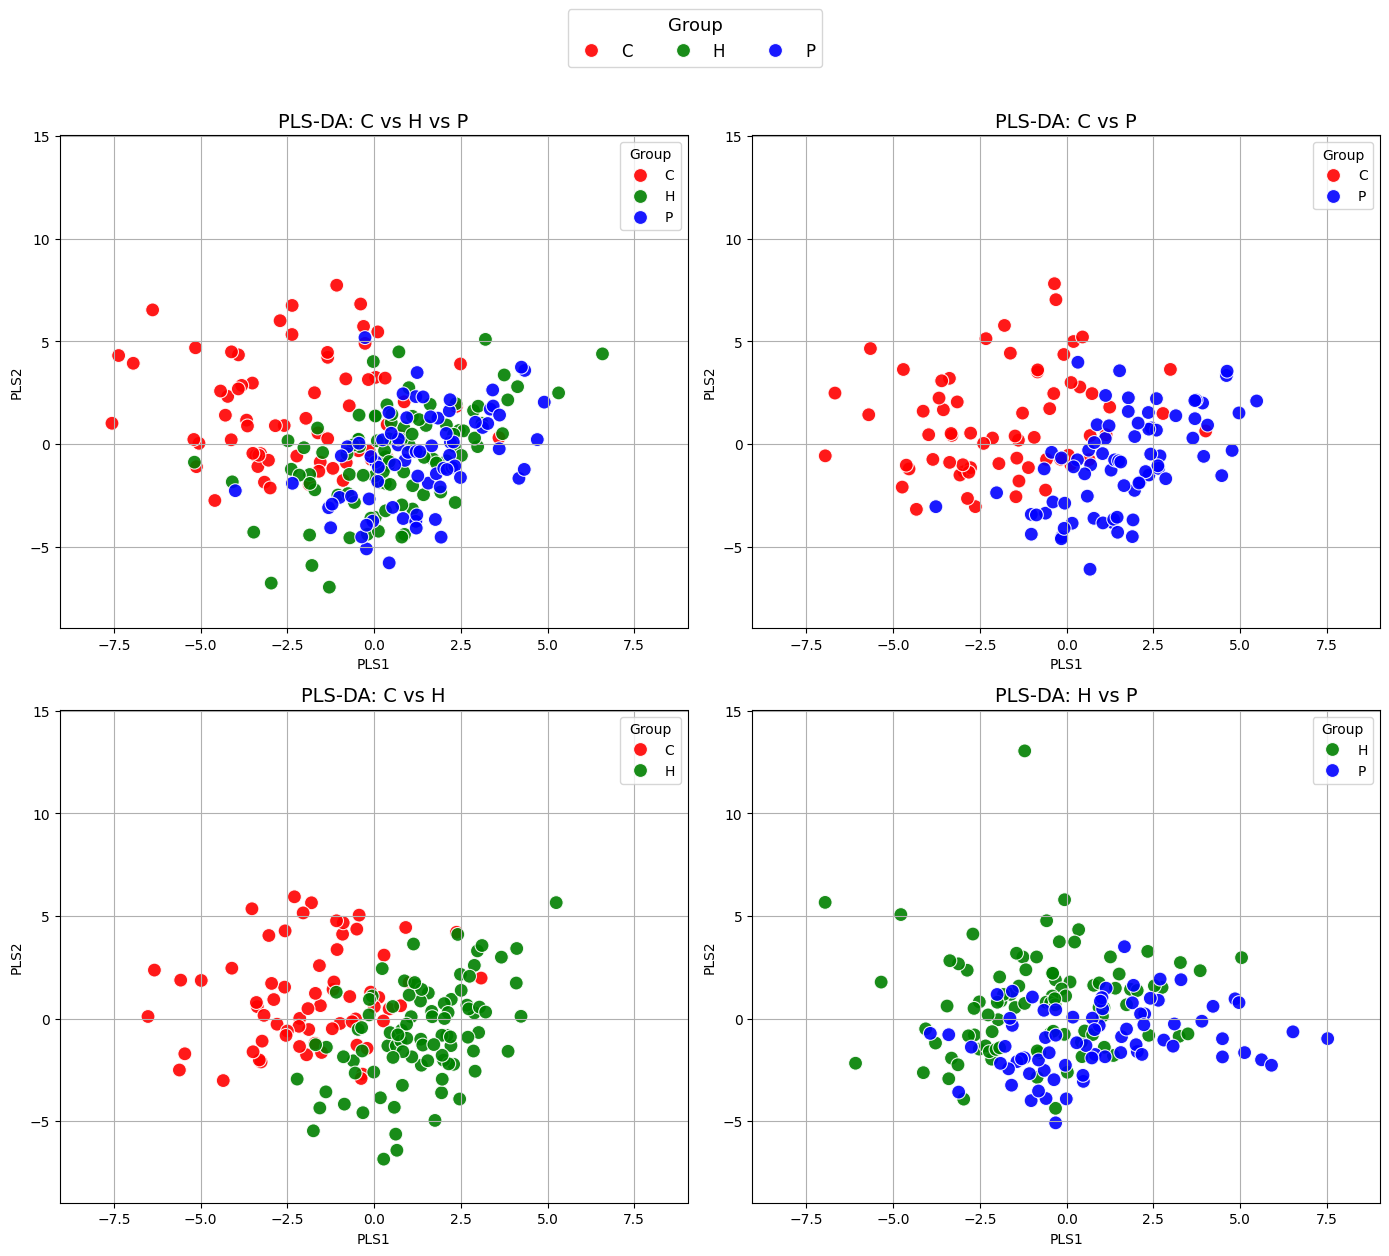

In [5]:

custom_palette = {'C': 'red', 'P': 'blue', 'H': 'green'}  # Define custom color palette


clinical_cols = ['Age at Consent', 'Height [cm]', 'Weight [kg]', 'BMI [kg/m²]']  # Clinical variables to exclude


def compute_pls_da(X, y, n_components=2):

    """

    Function to perform Partial Least Squares Discriminant Analysis (PLS-DA) on a dataset.

    """
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    pls = PLSRegression(n_components=n_components)
    X_pls = pls.fit_transform(X_scaled, y_encoded)[0]
    pls_df = pd.DataFrame(X_pls, columns=['PLS1', 'PLS2'])
    pls_df['Group'] = y.values
    return pls_df


comparisons = [                                          # Define comparisons
    ('C vs H vs P', df),
    ('C vs P', df[df['Groups'].isin(['C', 'P'])]),
    ('C vs H', df[df['Groups'].isin(['C', 'H'])]),
    ('H vs P', df[df['Groups'].isin(['H', 'P'])])
]


pls_dfs = []
x_min, x_max, y_min, y_max = float('inf'), float('-inf'), float('inf'), float('-inf')   # Compute all PLS-DA results

for title, subset_df in comparisons:

    X = subset_df.drop(columns=clinical_cols, errors='ignore').select_dtypes(include='number')  # Drop clinical variables and select only numeric metabolite columns
    y = subset_df['Groups']
    pls_df = compute_pls_da(X, y)
    pls_dfs.append((title, pls_df))


    x_min = min(x_min, pls_df['PLS1'].min())
    x_max = max(x_max, pls_df['PLS1'].max())
    y_min = min(y_min, pls_df['PLS2'].min())
    y_max = max(y_max, pls_df['PLS2'].max())


x_pad = (x_max - x_min) * 0.1       # Padding to avoid border overlaps
y_pad = (y_max - y_min) * 0.1
x_min -= x_pad
x_max += x_pad
y_min -= y_pad
y_max += y_pad


fig, axes = plt.subplots(2, 2, figsize=(14, 12))  # Plotting
axes = axes.flatten()

for ax, (title, pls_df) in zip(axes, pls_dfs):
    sns.scatterplot(
        data=pls_df,
        x='PLS1',
        y='PLS2',
        hue='Group',
        palette=custom_palette,
        s=100,
        alpha=0.9,
        ax=ax
    )
    ax.set_title(f'PLS-DA: {title}', fontsize=14)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('PLS1')
    ax.set_ylabel('PLS2')
    ax.grid(True)


handles, labels = axes[0].get_legend_handles_labels()   # Shared legend
fig.legend(
    handles,
    labels,
    title='Group',
    loc='upper center',
    bbox_to_anchor=(0.5, 1.05),
    ncol=3,
    fontsize=12,
    title_fontsize=13
)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


**PLS-DA Model Performance: Strong CRC vs. Polyp Separation Validated by Permutation Testing**

PLS-DA performance was evaluated using Monte Carlo cross-validation (MCCV) with area under the curve (AUC) as the metric. The CRC vs. polyp (C vs. P) comparison yielded the highest mean AUC (0.855), indicating strong group separation. CRC vs. healthy (C vs. H) also performed well (AUC = 0.844), whereas healthy vs. polyp (H vs. P) showed poor discrimination (AUC = 0.523). The multiclass model (C, P, H) achieved a moderate AUC of approximately 0.713. Among the pairwise comparisons, C vs. P demonstrated the most robust discriminatory power and is therefore the most promising target for further analysis and biomarker discovery. These findings also suggest the dataset is well-suited for early detection or risk stratification of polyp patients who may be at higher risk for CRC progression.

Permutation testing (n = 1000) confirmed the statistical significance of the observed AUCs (p-value = 0) for the multiclass model and for both C vs. P and C vs. H comparisons.



In [6]:
def run_binary_pls_auc(df, group_pair, n_iter=100, verbose=False):

    """
    Function to perform binary PLS-DA classification with repeated AUC estimation.

    """
    df_pair = df[df['Groups'].isin(group_pair)].copy()
    clinical_cols = ['Age at Consent', 'Height [cm]', 'Weight [kg]', 'BMI [kg/m²]']
    X = df_pair.drop(columns=clinical_cols, errors='ignore').select_dtypes(include='number')
    y = df_pair['Groups']

    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    auc_scores = []

    for i in range(n_iter):
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y_encoded, test_size=0.33, stratify=y_encoded, random_state=i
        )
        pls = PLSRegression(n_components=2, max_iter=1000)
        pls.fit(X_train, y_train)
        y_pred = pls.predict(X_test).ravel()

        auc = roc_auc_score(y_test, y_pred)
        auc_scores.append(auc)

    mean_auc = np.mean(auc_scores)
    ci_low, ci_high = st.t.interval(0.95, len(auc_scores)-1, loc=mean_auc, scale=st.sem(auc_scores))

    if verbose:
        print(f"\nGroups: {group_pair[0]} vs {group_pair[1]}")
        print(f"Mean AUC over {n_iter} iterations: {mean_auc:.3f}")
        print(f"95% CI: ({ci_low:.3f}, {ci_high:.3f})")

    return mean_auc, (ci_low, ci_high)

def run_multiclass_pls_auc(df, n_iter=100, verbose=False):

    """
    Function to perform multiclass PLS-DA classification with macro AUC evaluation.

    """

    X = df.select_dtypes(include='number')
    y = df['Groups']

    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    classes = np.unique(y_encoded)
    y_binarized = label_binarize(y_encoded, classes=classes)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    auc_scores = []

    for i in range(n_iter):
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y_encoded, test_size=0.33, stratify=y_encoded, random_state=i
        )

        y_train_bin = label_binarize(y_train, classes=classes)
        y_test_bin = label_binarize(y_test, classes=classes)

        pls = PLSRegression(n_components=len(classes) - 1)
        pls.fit(X_train, y_train_bin)
        y_pred = pls.predict(X_test)

        try:
            auc = roc_auc_score(y_test_bin, y_pred, multi_class='ovr', average='macro')
            auc_scores.append(auc)
        except ValueError:
            continue

    mean_auc = np.mean(auc_scores)
    ci_low, ci_high = st.t.interval(0.95, len(auc_scores)-1, loc=mean_auc, scale=st.sem(auc_scores))

    if verbose:
        print(f"\nMulticlass (C, P, H)")
        print(f"Mean AUC over {n_iter} iterations: {mean_auc:.3f}")
        print(f"95% CI: ({ci_low:.3f}, {ci_high:.3f})")

    return mean_auc, (ci_low, ci_high)



results = []                                 # Run all comparisons:

pairs = [('C', 'P'), ('C', 'H'), ('H', 'P')]
for g1, g2 in pairs:
    mean_auc, ci = run_binary_pls_auc(df, [g1, g2], n_iter=100)
    results.append({
        'Comparison': f"{g1} vs {g2}",
        'Mean AUC': mean_auc,
        '95% CI Lower': ci[0],
        '95% CI Upper': ci[1]
    })

mean_auc_multi, ci_multi = run_multiclass_pls_auc(df, n_iter=100)
results.append({
    'Comparison': "Multiclass (C vs P vs H)",
    'Mean AUC': mean_auc_multi,
    '95% CI Lower': ci_multi[0],
    '95% CI Upper': ci_multi[1]
})


summary_df = pd.DataFrame(results)    # Create summary DataFrame

print("\n=== AUC Summary ===")
print(summary_df)



=== AUC Summary ===
                 Comparison  Mean AUC  95% CI Lower  95% CI Upper
0                    C vs P  0.855291      0.845507      0.865074
1                    C vs H  0.843548      0.833858      0.853239
2                    H vs P  0.522761      0.510814      0.534709
3  Multiclass (C vs P vs H)  0.712994      0.706190      0.719797


**Variable Importance in Projection (VIP) Scores for PLS Model Features**

Note: variables with VIP scores > 1 are typically considered important contributors to the model.

In [7]:
X = df.select_dtypes(include='number')
y = df['Groups']                   # Target column


le = LabelEncoder()                # Encode target labels
y_encoded = le.fit_transform(y)


scaler = StandardScaler()           # Scale features
X_scaled = scaler.fit_transform(X)


pls = PLSRegression(n_components=2)   # Fit PLS model
pls.fit(X_scaled, y_encoded)


def calculate_vip_df(pls, X):         # VIP score calculation function
    t = pls.x_scores_
    w = pls.x_weights_
    q = pls.y_loadings_

    p, h = w.shape
    s = np.array([np.sum((t[:, i] * q[0, i]) ** 2) for i in range(h)])
    total_s = np.sum(s)

    vip_scores = np.array([
        np.sqrt(p * np.sum((w[j, :] ** 2) * s) / total_s)
        for j in range(p)
    ])

    return pd.DataFrame({'Metabolite': X.columns, 'VIP_Score': vip_scores}).sort_values(by='VIP_Score', ascending=False)


vip_df = calculate_vip_df(pls, X)   # Calculate VIP scores
print(vip_df.head())


                        Metabolite  VIP_Score
74       Lysine (147.1 / 84.0 (2))   2.135576
52    Glyceraldehyde (89.0 / 59.0)   2.026301
79       Methionine (150.1 / 61.0)   1.978416
72  Linolenic Acid (279.1 / 261.0)   1.924757
22    Aspartic Acid (132.0 / 88.0)   1.795308


**Significant Metabolite Differences Between CRC, Polyp, and Healthy Groups.**

We conducted independent two-sample t-tests to identify significantly altered metabolites between groups, adjusting p-values using the Benjamini-Hochberg FDR method to control for multiple comparisons. In the CRC vs Healthy (C vs H) comparison, several metabolites showed marked differential expression, highlighting disease-associated metabolic changes. Similarly, the CRC vs Polyp (C vs P) contrast revealed metabolites that may distinguish malignant from benign conditions, supporting their potential utility in early detection and risk stratification.

In [8]:
X = df.select_dtypes(include='number').copy()

group_C = X[df['Groups'] == 'C']
group_H = X[df['Groups'] == 'H']
group_P = X[df['Groups'] == 'P']


def run_ttest(group1, group2):
    """Function to perform independent t-test and FDR adjustment"""
    p_vals = []
    for col in X.columns:
        _, p = ttest_ind(group1[col], group2[col], nan_policy='omit')
        p_vals.append(p)
    df_out = pd.DataFrame({
        'Metabolite': X.columns,
        'p_value': p_vals
    })
    df_out['adj_p_value'] = multipletests(df_out['p_value'], method='fdr_bh')[1]
    return df_out.sort_values(by='p_value')


ttest_ch = run_ttest(group_C, group_H) # Run comparisons
ttest_cp = run_ttest(group_C, group_P)


print("Top metabolites C vs H:")
print(ttest_ch.head())

print("\nTop metabolites C vs P:")
print(ttest_cp.head())


Top metabolites C vs H:
                        Metabolite   p_value  adj_p_value
60       Histidine (156.1 / 110.0)  0.000002     0.000221
72  Linolenic Acid (279.1 / 261.0)  0.000035     0.001994
22    Aspartic Acid (132.0 / 88.0)  0.000096     0.003680
74       Lysine (147.1 / 84.0 (2))  0.000175     0.004023
50        Glutamine (147.1 / 84.0)  0.000201     0.004023

Top metabolites C vs P:
                         Metabolite   p_value  adj_p_value
74        Lysine (147.1 / 84.0 (2))  0.000001     0.000120
79        Methionine (150.1 / 61.0)  0.000005     0.000310
60        Histidine (156.1 / 110.0)  0.000019     0.000593
4   2'-Deoxyuridine (229.1 / 113.0)  0.000021     0.000593
72   Linolenic Acid (279.1 / 261.0)  0.000032     0.000747


**Metabolite Filtering Based on VIP Scores and Statistical Significance**

We selected metabolites that met two criteria: VIP scores > 1 and FDR-adjusted p-values < 0.05, focusing on the CRC vs Healthy and CRC vs Polyp comparisons. This combined statistical and biological filtering ensures the identified metabolites are both significant and potentially relevant for biomarker discovery.

In [9]:
merged_ch = pd.merge(vip_df, ttest_ch, on='Metabolite')                              # Merge and filter: C vs H
filtered_ch = merged_ch.query("VIP_Score > 1 and adj_p_value < 0.05") \
                       .sort_values(by=['VIP_Score', 'p_value'], ascending=[False, True])


merged_cp = pd.merge(vip_df, ttest_cp, on='Metabolite')                               # Merge and filter: C vs P
filtered_cp = merged_cp.query("VIP_Score > 1 and adj_p_value < 0.05") \
                       .sort_values(by=['VIP_Score', 'p_value'], ascending=[False, True])


print("Top C vs H Hits:")  # Display top hits
print(filtered_ch.head())

print("Top C vs P Hits:")
print(filtered_cp.head())


Top C vs H Hits:
                       Metabolite  VIP_Score   p_value  adj_p_value
0       Lysine (147.1 / 84.0 (2))   2.135576  0.000175     0.004023
1    Glyceraldehyde (89.0 / 59.0)   2.026301  0.000405     0.005816
2       Methionine (150.1 / 61.0)   1.978416  0.000210     0.004023
3  Linolenic Acid (279.1 / 261.0)   1.924757  0.000035     0.001994
4    Aspartic Acid (132.0 / 88.0)   1.795308  0.000096     0.003680
Top C vs P Hits:
                       Metabolite  VIP_Score   p_value  adj_p_value
0       Lysine (147.1 / 84.0 (2))   2.135576  0.000001     0.000120
1    Glyceraldehyde (89.0 / 59.0)   2.026301  0.000206     0.002369
2       Methionine (150.1 / 61.0)   1.978416  0.000005     0.000310
3  Linolenic Acid (279.1 / 261.0)   1.924757  0.000032     0.000747
4    Aspartic Acid (132.0 / 88.0)   1.795308  0.000141     0.001945


In [10]:
print(f"Number of significant metabolites (C vs H): {filtered_ch.shape[0]}")
print(f"Number of significant metabolites (C vs P): {filtered_cp.shape[0]}")


Number of significant metabolites (C vs H): 15
Number of significant metabolites (C vs P): 22


**VIP Scores of Statistically Significant Metabolites (VIP > 1 & adj. p < 0.05)**

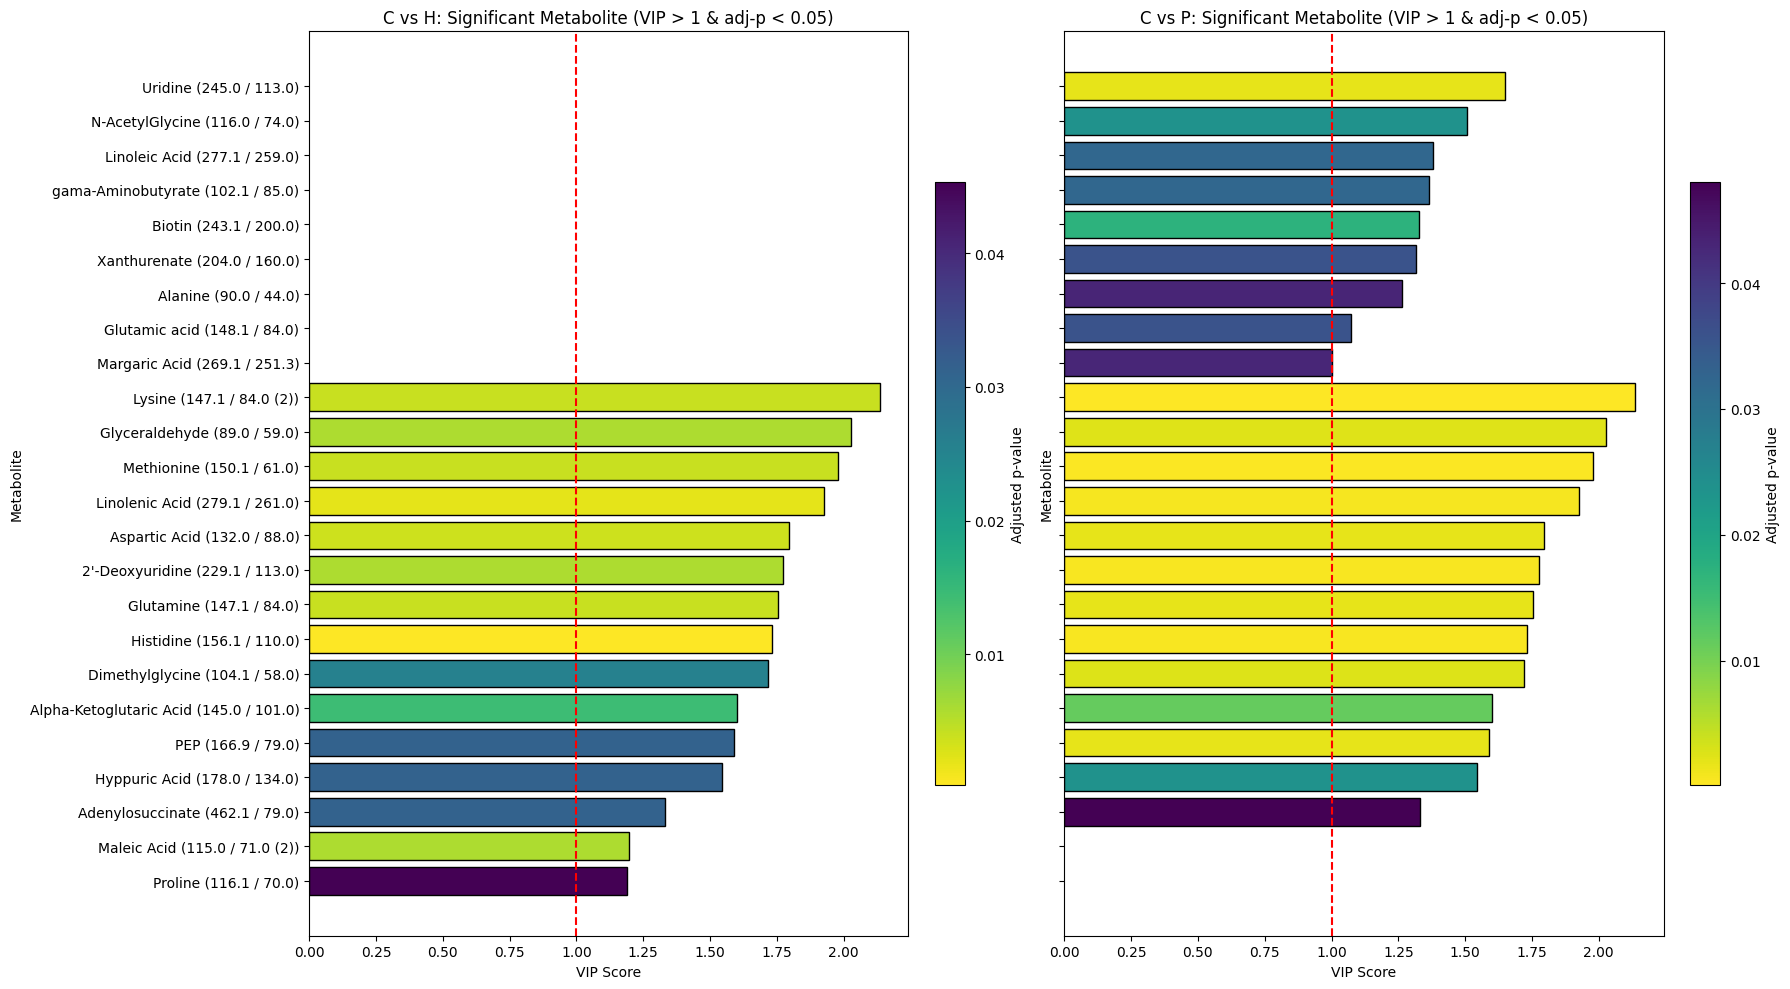

In [11]:
def plot_vip_scores(ax, filtered_df, title):   # Plot horizontal VIP scores bar chart colored by adjusted p-values

    top_hits = filtered_df.sort_values(by='VIP_Score', ascending=True)
    norm = plt.Normalize(top_hits['adj_p_value'].min(), top_hits['adj_p_value'].max())
    colors = plt.cm.viridis_r(norm(top_hits['adj_p_value']))

    bars = ax.barh(
        y=top_hits['Metabolite'],
        width=top_hits['VIP_Score'],
        color=colors,
        edgecolor='black'
    )
    ax.axvline(x=1, color='red', linestyle='--', label='VIP = 1')
    ax.set_title(title)
    ax.set_xlabel('VIP Score')
    ax.set_ylabel('Metabolite')
    ax.invert_yaxis()      # keep highest VIP on top


    sm = plt.cm.ScalarMappable(cmap='viridis_r', norm=norm)   # Create colorbar for this subplot
    sm.set_array([])
    return sm

fig, axes = plt.subplots(1, 2, figsize=(18, 10), sharey=True)

sm1 = plot_vip_scores(axes[0], filtered_ch, 'C vs H: Significant Metabolite (VIP > 1 & adj-p < 0.05)')
sm2 = plot_vip_scores(axes[1], filtered_cp, 'C vs P: Significant Metabolite (VIP > 1 & adj-p < 0.05)')


cbar1 = fig.colorbar(sm1, ax=axes[0], fraction=0.046, pad=0.04)  # Add colorbars on the right side of each subplot
cbar1.set_label('Adjusted p-value')

cbar2 = fig.colorbar(sm2, ax=axes[1], fraction=0.046, pad=0.04)
cbar2.set_label('Adjusted p-value')

plt.tight_layout()
plt.show()


**Log₂ Fold Change of Metabolites (CRC vs Healthy)**








In [12]:
crc_means = df[df['Groups'] == 'C'][metabolite_cols].mean()   # Group by 'Groups' column
healthy_means = df[df['Groups'] == 'H'][metabolite_cols].mean()


log2fc = np.log2((crc_means + 1e-8) / (healthy_means + 1e-8)) # Avoid division by zero


log2fc_df = pd.DataFrame({'Metabolite': log2fc.index, 'log2fc': log2fc.values}) # Convert to DataFrame


**Merged Log₂ Fold Change with Significant Metabolites (VIP > 1 & FDR < 0.05)**

In [13]:
filtered_df_ch = filtered_ch.merge(log2fc_df, on='Metabolite', how='left')
filtered_df_cp = filtered_cp.merge(log2fc_df, on='Metabolite', how='left')


**Volcano Plots of Metabolite Regulation: CRC vs Healthy and Polyp**

The plot highlights metabolites with both large changes and strong statistical support.










In [14]:
filtered_df_ch['-log10(p)'] = -np.log10(filtered_df_ch['p_value'])              # Prepare data for C vs H

def label_direction(row):
    """
    Function to generate volcano plots for CRC vs Healthy and CRC vs Polyp
    showing log2 fold change and significance with regulation status.
    """

    if row['p_value'] < 0.05:
        return 'Upregulated' if row['log2fc'] > 0 else 'Downregulated'
    return 'Not significant'

filtered_df_ch['Regulation'] = filtered_df_ch.apply(label_direction, axis=1)


filtered_df_cp['-log10(p)'] = -np.log10(filtered_df_cp['p_value'])              # Prepare data for C vs P
filtered_df_cp['Regulation'] = filtered_df_cp.apply(label_direction, axis=1)


fig = make_subplots(                                                            # Create subplot with reduced spacing
    rows=1, cols=2,
    subplot_titles=('C vs H', 'C vs P'),
    shared_yaxes=True,
    horizontal_spacing=0.05
)


color_map = {                                                                   # Color mapping
    'Upregulated': 'red',
    'Downregulated': 'blue',
    'Not significant': 'gray'
}


legend_flags = {                                                                # Legend flags
    'Upregulated': True,
    'Downregulated': True,
    'Not significant': True
}


for regulation in ['Upregulated', 'Downregulated', 'Not significant']:          # C vs H
    df_sub = filtered_df_ch[filtered_df_ch['Regulation'] == regulation]
    fig.add_trace(
        go.Scatter(
            x=df_sub['log2fc'],
            y=df_sub['-log10(p)'],
            mode='markers',
            marker=dict(color=color_map[regulation], size=8, line=dict(width=0.5, color='DarkSlateGrey')),
            name=regulation,
            legendgroup=regulation,
            showlegend=legend_flags[regulation],
            text=df_sub['Metabolite'],
            hovertemplate=(
                'Metabolite: %{text}<br>' +
                'log2FC: %{x:.2f}<br>' +
                '-log10(p): %{y:.2f}<extra></extra>'
            )
        ),
        row=1, col=1
    )
    legend_flags[regulation] = False


for regulation in ['Upregulated', 'Downregulated', 'Not significant']:          # C vs P
    df_sub = filtered_df_cp[filtered_df_cp['Regulation'] == regulation]
    fig.add_trace(
        go.Scatter(
            x=df_sub['log2fc'],
            y=df_sub['-log10(p)'],
            mode='markers',
            marker=dict(color=color_map[regulation], size=8, line=dict(width=0.5, color='DarkSlateGrey')),
            name=regulation,
            legendgroup=regulation,
            showlegend=False,
            text=df_sub['Metabolite'],
            hovertemplate=(
                'Metabolite: %{text}<br>' +
                'log2FC: %{x:.2f}<br>' +
                '-log10(p): %{y:.2f}<extra></extra>'
            )
        ),
        row=1, col=2
    )


for col in [1, 2]:                                                              # Threshold lines
    fig.add_hline(y=-np.log10(0.05), line_dash="dash", line_color="gray",
                  annotation_text="p = 0.05", annotation_position="top left",
                  row=1, col=col)
    fig.add_vline(x=0, line_dash="dash", line_color="black", row=1, col=col)


fig.update_xaxes(title_text='log2 Fold Change', row=1, col=1)                   # Axis labels
fig.update_xaxes(title_text='log2 Fold Change', row=1, col=2)
fig.update_yaxes(title_text='-log10(p-value)', row=1, col=1)


fig.update_layout(                                                              # Layout
    height=600, width=1000,
    legend_title_text='Regulation',
    template='plotly_white'
)

fig.show()


**Heatmaps of Differential Metabolites in CRC vs Healthy and Polyp Groups**

Heatmaps display scaled expression levels of significant metabolites across samples, grouped by condition. Color intensity reflects relative abundance, and clustering is omitted to highlight group-wise patterns.

In [15]:
df_ch = df[df['Groups'].isin(['C', 'H'])].copy()     # C vs H
X_ch = df_ch.select_dtypes(include='number')
sig_metabs_ch = filtered_df_ch['Metabolite'].tolist()
X_sig_ch = X_ch[sig_metabs_ch]


X_scaled_ch = pd.DataFrame(                         # Z-score scaling
    StandardScaler().fit_transform(X_sig_ch),
    columns=sig_metabs_ch,
    index=X_ch.index
)

fig_ch = go.Figure(
    data=go.Heatmap(
        z=X_scaled_ch.values,
        x=X_scaled_ch.columns,
        y=X_scaled_ch.index,
        colorscale='RdBu_r',
        zmin=-2, zmax=2,
        colorbar=dict(title='Z-score')
    )
)
fig_ch.update_layout(
    title='Heatmap of Significant Metabolites (C vs H)',
    xaxis_title='Metabolites',
    yaxis_title='Samples',
    template='plotly_white',
    width=800, height=600
)

fig_ch.show()


df_cp = df[df['Groups'].isin(['C', 'P'])].copy()             # C vs P
X_cp = df_cp.select_dtypes(include='number')
sig_metabs_cp = filtered_df_cp['Metabolite'].tolist()
X_sig_cp = X_cp[sig_metabs_cp]


X_scaled_cp = pd.DataFrame(                                 # Z-score scaling
    StandardScaler().fit_transform(X_sig_cp),
    columns=sig_metabs_cp,
    index=X_cp.index
)

fig_cp = go.Figure(
    data=go.Heatmap(
        z=X_scaled_cp.values,
        x=X_scaled_cp.columns,
        y=X_scaled_cp.index,
        colorscale='RdBu_r',
        zmin=-2, zmax=2,
        colorbar=dict(title='Z-score')
    )
)
fig_cp.update_layout(
    title='Heatmap of Significant Metabolites (C vs P)',
    xaxis_title='Metabolites',
    yaxis_title='Samples',
    template='plotly_white',
    width=800, height=600
)

fig_cp.show()


# Disease Signature Enrichment Highlights CRC as Top Hit in C vs H and C vs P

We performed disease signature enrichment using MetaboAnalyst’s blood-based metabolite set library. In both Cancer vs Healthy and Cancer vs Polyp comparisons, the colorectal cancer signature was ranked as the top enriched set, with highly significant adjusted p-values and the highest enrichment ratios. This underscores the biological relevance and diagnostic potential of the detected metabolite profile for CRC.

In [16]:

from IPython.display import display, Markdown


df_ch = pd.read_csv("msea_ora_result_C_vs_H_blood.csv")   # Load the CSVs
df_cp = pd.read_csv("msea_ora_result_C_vs_P_blood.csv")


df_ch.rename(columns={df_ch.columns[0]: "Metabolite Set"}, inplace=True)   # Rename first column to 'Metabolite Set'
df_cp.rename(columns={df_cp.columns[0]: "Metabolite Set"}, inplace=True)


df_ch["Enrichment Ratio"] = df_ch["hits"] / df_ch["expected"]   # Compute enrichment ratio and -log10(p)
df_cp["Enrichment Ratio"] = df_cp["hits"] / df_cp["expected"]

df_ch["-log10(p)"] = -np.log10(df_ch["Raw p"])
df_cp["-log10(p)"] = -np.log10(df_cp["Raw p"])


display(Markdown("#### Cancer vs Healthy (C vs H) - Disease Signature Enrichment"))  # Display with section titles
display(df_ch.head())

display(Markdown("#### Cancer vs Polyp (C vs P) - Disease Signature Enrichment"))
display(df_cp.head())


#### Cancer vs Healthy (C vs H) - Disease Signature Enrichment

,Metabolite Set,total,expected,hits,Raw p,Holm p,FDR,Enrichment Ratio,-log10(p)
0,Colorectal cancer,54,0.02520,7,5.160000e-17,1.440000e-14,1.440000e-14,277.777778,16.287350
1,Schizophrenia,101,0.04720,6,1.960000e-12,5.460000e-10,2.740000e-10,127.118644,11.707744
2,Fumarase deficiency,13,0.00607,4,1.710000e-11,4.750000e-09,1.600000e-09,658.978583,10.767004
3,Epilepsy,15,0.00700,4,3.260000e-11,9.040000e-09,2.280000e-09,571.428571,10.486782
4,Alzheimer's disease,59,0.02750,4,1.080000e-08,2.970000e-06,6.030000e-07,145.454545,7.966576


#### Cancer vs Polyp (C vs P) - Disease Signature Enrichment

,Metabolite Set,total,expected,hits,Raw p,Holm p,FDR,Enrichment Ratio,-log10(p)
0,Colorectal cancer,54,0.0403,10,3.390000e-23,9.500000e-21,9.500000e-21,248.138958,22.469800
1,Schizophrenia,101,0.0755,10,2.690000e-20,7.510000e-18,3.770000e-18,132.450331,19.570248
2,Epilepsy,15,0.0112,6,2.980000e-16,8.290000e-14,2.780000e-14,535.714286,15.525784
3,Pancreatic cancer,21,0.0157,5,2.350000e-12,6.510000e-10,1.480000e-10,318.471338,11.628932
4,Alzheimer's disease,59,0.0441,6,2.640000e-12,7.280000e-10,1.480000e-10,136.054422,11.578396


**Visualization of Top Enriched Metabolite Sets (C vs H and C vs P)**

This plot builds upon the enrichment results computed in the previous step, where enrichment ratios and –log₁₀(p-values) were calculated from MetaboAnalyst outputs. Bar and dot plots illustrate the top 25 enriched disease-related metabolite sets for each comparison (C vs H and C vs P), with color and size encoding statistical significance and number of hits, respectively.

In [17]:
def truncate_labels(df, max_length=40):  # Helper function to truncate long names
    df = df.copy()
    df["Metabolite Set"] = df["Metabolite Set"].apply(
        lambda x: x if len(x) <= max_length else x[:max_length] + "..."
    )
    return df


def plot_enrichment(df, title):        # Plotting function
    # Sort and select top 25
    df_sorted = df.sort_values("Raw p", ascending=True).head(25)
    df_sorted = truncate_labels(df_sorted)


    fig = make_subplots(
        rows=1, cols=2, shared_yaxes=True,
        subplot_titles=("Bar Chart", "Dot plot"),
        horizontal_spacing=0.15
    )

                                        # Bar Plot (left)
    fig.add_trace(go.Bar(
        x=df_sorted["Enrichment Ratio"],
        y=df_sorted["Metabolite Set"],
        orientation='h',
        marker=dict(
            color=df_sorted["-log10(p)"],
            colorscale='Plasma',
            colorbar=dict(
                title='-log10(p)',
                len=0.5,
                y=0.75,
                x=0.42
            ),
            reversescale=True
        ),
        showlegend=False
    ), row=1, col=1)

                                        # Dot Plot (right)
    marker_size_scale = 20
    fig.add_trace(go.Scatter(
        x=df_sorted["-log10(p)"],
        y=df_sorted["Metabolite Set"],
        mode='markers',
        marker=dict(
            size=df_sorted["hits"] * marker_size_scale,
            color=df_sorted["Enrichment Ratio"],
            colorscale='Viridis',
            colorbar=dict(
                title='Enrichment Ratio',
                len=0.5,
                y=0.25,
                x=1.05
            ),
            showscale=True,
            sizemode='area',
            sizeref=2.*max(df_sorted["hits"]*marker_size_scale)/(40.**2),
            sizemin=4
        ),
        showlegend=False
    ), row=1, col=2)


    fig.update_yaxes(title_text="Metabolite Set", autorange="reversed", row=1, col=1)
    fig.update_yaxes(autorange="reversed", row=1, col=2)

    fig.update_xaxes(title_text="Enrichment Ratio", row=1, col=1)
    fig.update_xaxes(title_text="-log10(p)", row=1, col=2)

                                               # Layout
    fig.update_layout(
        height=800,
        width=1150,
        margin=dict(l=220, r=120, t=100, b=80),
        title_text=title
    )

    fig.show()


plot_enrichment(df_ch, "Enriched Metabolite Sets – C vs H (Top 25)")
plot_enrichment(df_cp, "Enriched Metabolite Sets – C vs P (Top 25)")


# Key Findings

- The **Colorectal Cancer (CRC) signature ranked #1** in both comparisons.
- CRC-related metabolites detected:
  - **7 out of 54** in **C vs H**
  - **10 out of 54** in **C vs P**

This indicates a **strong CRC-specific metabolic signature** that clearly distinguishes cancer from both healthy and polyp tissue. The even greater enrichment in the **C vs P** comparison suggests **progressive metabolic reprogramming** as tissue advances from polyp to cancer.



### Notable Metabolite Patterns
---

**Shared across both C vs H and C vs P: ✔ / ✔**  
- Glutamine  
- Hippuric acid  
- Histidine  
- L-Aspartic acid  
- Lysine  
- Methionine

**Detected only in C vs H: ✔ / ✘**  
- Proline

**Detected only in C vs P: ✘ / ✔**  
- Glutamic acid  
- Uridine  
- Linoleic acid  
- L-Alanine



### Biological Implications
---

- The **C vs P-unique metabolites** (e.g., *Uridine*, *Linoleic acid*) may serve as **biomarkers of malignant transformation**, helping to distinguish cancer from precancerous polyps.
- The presence of **Proline** only in C vs H suggests it may reflect **early-stage metabolic changes** that diminish or disappear during full tumor progression.



### Conclusion
---

These findings confirm that:

- Blood-based metabolomic profiling can capture **core CRC biology**
- **Distinct metabolic shifts** occur as tissues progress from healthy to polyp to cancer
- Several metabolites show promise as **non-invasive biomarkers** for **early detection**, **risk stratification**, and **monitoring progression** in colorectal cancer


# Pathway Enrichment: C vs P Significant Metabolites

In [18]:
pathway = pd.read_csv('pathway_results.csv')
pathway.head()

,Pathway Name,Total,Expected,Hits,Raw p,log(P),Holm adjust,FDR,Impact
0,"Alanine, aspartate and glutamate metabolism",28,0.29899,7,4.040000e-09,8.3939,3.230000e-07,3.230000e-07,0.69071
1,Arginine biosynthesis,14,0.14950,4,8.370000e-06,5.0775,6.609200e-04,3.346400e-04,0.12234
2,Butanoate metabolism,15,0.16018,3,4.257000e-04,3.3709,3.320400e-02,1.040900e-02,0.03175
3,Histidine metabolism,16,0.17085,3,5.204700e-04,3.2836,4.007600e-02,1.040900e-02,0.22131
4,Nitrogen metabolism,6,0.06407,2,1.570700e-03,2.8039,1.193700e-01,2.513100e-02,0.00000


In [20]:
import plotly.express as px

fig = px.scatter(
    pathway,
    x="Impact",
    y="log(P)",
    color="FDR",
    hover_name="Pathway Name",
    color_continuous_scale="Viridis",
    title="Pathway Analysis Overview: CRC vs Polyp",
)


                                                         # Uniform bubble size
fig.update_traces(marker=dict(size=12))

                                                          # Final layout styling
fig.update_layout(
    width=600,
    height=600,
    template="plotly_white",
    xaxis_title="Pathway Impact",
    yaxis_title="-log10(p-value)",

    xaxis=dict(
        showgrid=False,
        zeroline=False,
        linecolor='black',
        linewidth=1,
        ticks="outside",
        ticklen=5,
        dtick=0.2

    ),

    yaxis=dict(
        showgrid=False,
        zeroline=False,
        linecolor='black',
        linewidth=1,
        ticks="outside",
        ticklen=5,
        tickmode="linear",
        dtick=2
    ),

    coloraxis_colorbar=dict(
        thickness=12,
        len=0.4,
        x=1.2,
        y=0.6,
        title="FDR"
    )
)

fig.show()


# Key Findings
We prioritized the Cancer vs. Polyp (C vs P) comparison for pathway enrichment because it captured most of the significant metabolites identified in the Cancer vs. Healthy (C vs H) analysis, while also revealing additional markers and showing stronger statistical enrichment.

This aligns with PLS-DA results, which showed greater group separation for C vs P and an ROC AUC of 0.855, indicating solid discriminative performance.

## Top enriched pathways in the C vs P comparison:


- **Alanine, aspartate and glutamate metabolism** (hsa00250):

  The most significantly enriched pathway, with the highest impact score, indicating substantial shifts in amino acid turnover and central energy metabolism—key processes supporting tumor growth and nitrogen balance.

- **Arginine biosynthesis** (hsa00220):

  Enrichment in this pathway suggests alterations in the urea cycle, polyamine biosynthesis, and immune signaling, reflecting increased proliferative and immunometabolic demands during CRC progression.

## Other notable pathways:

- **Histidine metabolism** (hsa00340):

  Suggests involvement in histamine synthesis, nucleotide turnover, and potential links to immune regulation and cellular proliferation in colorectal cancer.

- **Butanoate metabolism** (hsa00650):

  Indicates altered handling of microbiota-derived short-chain fatty acids like butyrate. While butyrate plays a beneficial role in healthy colonocytes, its metabolism may become dysregulated in cancer, affecting energy utilization and epigenetic regulation.

- **Nitrogen metabolism** (hsa00910):

  Despite a low topological impact score, its statistical significance points to disrupted nitrogen handling, consistent with elevated biosynthetic demands in tumor cells.

These results support C vs P as a more informative comparison for capturing the metabolic reprogramming underlying malignant transformation in colorectal cancer.

For deeper mechanistic insights, readers may refer to these pathways in the KEGG database or other curated pathway resources.



# Network Analysis: Metabolic Pathway Connectivity

Functional Network Analysis of Differentially Expressed Metabolites using Metaboabalyst 6.

In [19]:
network_analysis= pd.read_csv("network_enrichment_pathway_0.csv")
network_analysis.head()

,Pathway,Total,Expected,Hits,Pval,FDR
0,"Alanine, aspartate and glutamate metabolism",28,0.413,7,3.710000e-08,0.000003
1,Arginine biosynthesis,14,0.206,4,2.970000e-05,0.001070
2,Butanoate metabolism,15,0.221,3,1.090000e-03,0.019100
3,Biotin metabolism,4,0.059,2,1.210000e-03,0.019100
4,Histidine metabolism,16,0.236,3,1.330000e-03,0.019100


**Side-by-Side Visualization of Top Metabolite Regulation in Enriched CRC Network Pathways**

In [20]:
from IPython.display import display, HTML

# Alanine, Aspartate, and Glutamate metabolism
data_alanine = [
    {"KEGG_ID": "C00049", "Name": "L-Aspartic acid", "logFC": 1.368697},
    {"KEGG_ID": "C00064", "Name": "Glutamine", "logFC": -0.921627},
    {"KEGG_ID": "C00026", "Name": "Oxoglutaric acid", "logFC": -0.928341},
    {"KEGG_ID": "C00334", "Name": "gamma-Aminobutyric acid", "logFC": -0.925653},
    {"KEGG_ID": "C03794", "Name": "Adenylsuccinic acid", "logFC": 1.208395},
    {"KEGG_ID": "C00041", "Name": "L-Alanine", "logFC": -0.939971},
    {"KEGG_ID": "C00025", "Name": "Glutamic acid", "logFC": 1.216847}
]
df_alanine = pd.DataFrame(data_alanine)
df_alanine['Regulation'] = df_alanine['logFC'].apply(lambda x: 'Upregulated' if x > 0 else 'Downregulated')

# Arginine biosynthesis
data_arginine = [
    {"KEGG_ID": "C00049", "Name": "L-Aspartic acid", "logFC": 1.368697},
    {"KEGG_ID": "C00064", "Name": "Glutamine", "logFC": -0.921627},
    {"KEGG_ID": "C00026", "Name": "Oxoglutaric acid", "logFC": -0.928341},
    {"KEGG_ID": "C00025", "Name": "Glutamic acid", "logFC": 1.216847}
]
df_arginine = pd.DataFrame(data_arginine)
df_arginine['Regulation'] = df_arginine['logFC'].apply(lambda x: 'Upregulated' if x > 0 else 'Downregulated')

# Display side-by-side
html = f"""
<div style="display: flex; gap: 40px;">
    <div>
        <h4>Alanine, Aspartate & Glutamate Metabolism</h4>
        {df_alanine.to_html(index=False)}
    </div>
    <div>
        <h4>Arginine Biosynthesis</h4>
        {df_arginine.to_html(index=False)}
    </div>
</div>
"""

display(HTML(html))


KEGG_ID,Name,logFC,Regulation
C00049,L-Aspartic acid,1.368697,Upregulated
C00064,Glutamine,-0.921627,Downregulated
C00026,Oxoglutaric acid,-0.928341,Downregulated
C00334,gamma-Aminobutyric acid,-0.925653,Downregulated
C03794,Adenylsuccinic acid,1.208395,Upregulated
C00041,L-Alanine,-0.939971,Downregulated
C00025,Glutamic acid,1.216847,Upregulated
KEGG_ID,Name,logFC,Regulation
C00049,L-Aspartic acid,1.368697,Upregulated
C00064,Glutamine,-0.921627,Downregulated


## Pathway and Network Analysis Summary
---
Both enrichment and network analyses consistently identified Alanine, aspartate & glutamate metabolism as the most significantly altered pathway (7 hits; FDR = 3.7 × 10⁻⁶), reflecting coordinated disruptions in amino acid turnover, nitrogen balance, and TCA cycle intermediates. Arginine biosynthesis (4 hits; FDR = 0.0011) was also prominently enriched, highlighting changes in urea cycle and polyamine metabolism relevant to cell proliferation and immune modulation.

Additional pathways of interest included Histidine metabolism, Butanoate metabolism, and Biotin metabolism, each contributing unique functional insights—from nucleotide and cofactor demands to potential microbiota-derived influences on tumor metabolism.

Together, these findings point to a network of interconnected metabolic changes supporting malignant transformation in colorectal cancer.

# Predictive Modeling of Colorectal Cancer vs Polyp Using 22 Preselected Metabolites and Machine Learning

Selected Top 10 Features:
['Methionine (150.1 / 61.0)', 'Glyceraldehyde (89.0 / 59.0)', 'Uridine (245.0 / 113.0)', "2'-Deoxyuridine (229.1 / 113.0)", 'PEP (166.9 / 79.0)', 'Linolenic Acid (279.1 / 261.0)', 'N-AcetylGlycine (116.0 / 74.0)', 'Hyppuric Acid (178.0 / 134.0)', 'Lysine (147.1 / 84.0 (2))', 'Margaric Acid (269.1 / 251.3)']

 Classification Report:
              precision    recall  f1-score   support

       Polyp       0.82      0.88      0.85        16
         CRC       0.83      0.77      0.80        13

    accuracy                           0.83        29
   macro avg       0.83      0.82      0.82        29
weighted avg       0.83      0.83      0.83        29


 Confusion Matrix:
[[14  2]
 [ 3 10]]

 Test AUC: 0.865


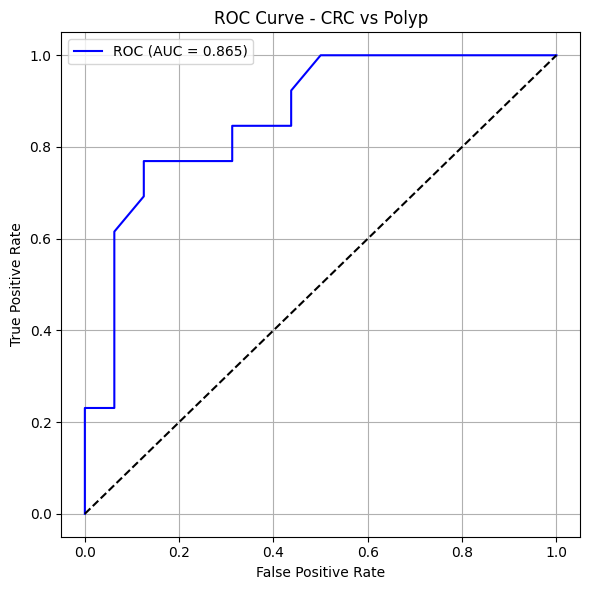


 5-Fold CV Accuracy: 0.775 ± 0.048


In [23]:

sig_metabolites_cp = [                                                          # Define 22 significant metabolites (CRC vs Polyp)
    'Glutamic acid (148.1 / 84.0)',
    'Aspartic Acid (132.0 / 88.0)',
    'Glutamine (147.1 / 84.0)',
    'Methionine (150.1 / 61.0)',
    'Alanine (90.0 / 44.0)',
    'Glyceraldehyde (89.0 / 59.0)',
    'Uridine (245.0 / 113.0)',
    'Linoleic Acid (277.1 / 259.0)',
    "2'-Deoxyuridine (229.1 / 113.0)",
    'PEP (166.9 / 79.0)',
    'Dimethylglycine (104.1 / 58.0)',
    'Histidine (156.1 / 110.0)',
    'Xanthurenate (204.0 / 160.0)',
    'gama-Aminobutyrate (102.1 / 85.0)',
    'Alpha-Ketoglutaric Acid (145.0 / 101.0)',
    'Biotin (243.1 / 200.0)',
    'Linolenic Acid (279.1 / 261.0)',
    'N-AcetylGlycine (116.0 / 74.0)',
    'Adenylosuccinate (462.1 / 79.0)',
    'Hyppuric Acid (178.0 / 134.0)',
    'Lysine (147.1 / 84.0 (2))',
    'Margaric Acid (269.1 / 251.3)'
]



                                                                                # Filter for CRC vs Polyp
df_cp = df[df['Groups'].isin(['C', 'P'])].copy()
df_cp = df_cp.dropna(subset=sig_metabolites_cp + ['Groups'])


                                                                                # Define feature matrix and labels
X = df_cp[sig_metabolites_cp]
y = df_cp['Groups'].map({'C': 1, 'P': 0}).astype(int)

                                                                                # Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

                                                                                # Recursive Feature Eliminatio(RFE) + Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rfe = RFE(estimator=rf, n_features_to_select=10)
rfe.fit(X_train, y_train)

                                                                                # Get top 10 features
selected_features = X.columns[rfe.support_]
X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]

                                                                                # Model training
rf.fit(X_train_sel, y_train)
y_pred = rf.predict(X_test_sel)
y_proba = rf.predict_proba(X_test_sel)[:, 1]

                                                                                # Model Evaluation
print("Selected Top 10 Features:")
print(list(selected_features))

print("\n Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Polyp', 'CRC']))

print("\n Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

                                                                                # AUC + ROC
test_auc = roc_auc_score(y_test, y_proba)
print(f"\n Test AUC: {test_auc:.3f}")

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC (AUC = {test_auc:.3f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - CRC vs Polyp")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

                                                                                # Cross-validation accuracy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf, X[selected_features], y, cv=cv, scoring='accuracy')
print(f"\n 5-Fold CV Accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

                                                                                # Feature Importance DataFrame
feat_imp = pd.DataFrame({
    'Feature': selected_features,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

                                                                                # Bar Chart
fig = px.bar(
    feat_imp,
    x='Importance',
    y='Feature',
    orientation='h',
    color='Importance',
    color_continuous_scale='Turbo',
    title='Top 10 Metabolites (RFE + RF Feature Importance)',
    labels={'Importance': 'Feature Importance', 'Feature': 'Metabolite'}
)

fig.update_layout(
    yaxis={'categoryorder': 'total ascending'},
    font=dict(size=14),
    height=500,
    width=800,
    plot_bgcolor='rgba(0,0,0,0)'
)

fig.show()


# Results Summary

We developed a Random Forest classifier to differentiate colorectal cancer (CRC) from polyp samples using targeted metabolomics data. Starting from 22 statistically significant metabolites, Recursive Feature Elimination (RFE) was applied to select the top 10 features for the model.

The top-10 metabolite model demonstrated strong predictive performance, achieving a test accuracy of 83%, an AUC of 0.865, and a 5-fold cross-validation accuracy of 77.5% ± 4.8%. In comparison, the model trained on the full set of 22 metabolites yielded a slightly lower AUC (0.849) and a reduced recall for the CRC class (0.62 vs. 0.77). This highlights the improved predictive focus and generalization offered by the more streamlined top-10 feature model.

However, this refinement came at a biological trade-off: while the full 22-metabolite set showed strong CRC enrichment in MetaboAnalyst's blood disease signature database (10 hits out of 54 known CRC markers), the reduced 10-feature model included only 4 of these known markers. Notably, the remaining 6 top features, although not previously annotated among known CRC markers, may represent novel candidate biomarkers that deserve further investigation as they could capture additional metabolic changes relevant to CRC progression.

**Limitations**: The model evaluation relied on a relatively small test set (n=29), which limits the robustness and generalizability of the performance metrics. This small sample size increases the risk of overfitting and may not fully capture the variability present in larger, independent cohorts. Therefore, further validation on larger datasets is essential to confirm the clinical utility and reproducibility of this metabolite signature.

# CRC vs Healthy – Random Forest Model with Top 20 RFE-Selected Metabolites

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.86      0.95      0.90        19
         CRC       0.91      0.77      0.83        13

    accuracy                           0.88        32
   macro avg       0.88      0.86      0.87        32
weighted avg       0.88      0.88      0.87        32

Confusion Matrix:
[[18  1]
 [ 3 10]]
Test AUC: 0.923


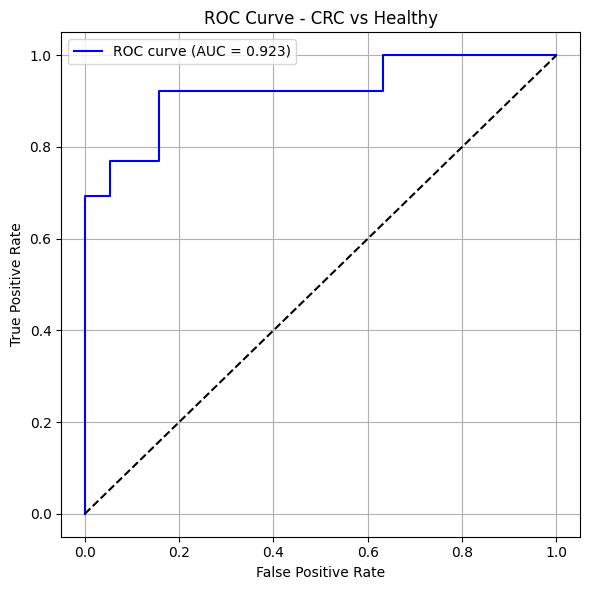

Average 5-Fold CV Accuracy: 0.7778225806451614
Selected Features: ['Acetoacetate (101.0 / 57.0)', 'Adenylosuccinate (462.1 / 79.0)', 'Alpha-Ketoglutaric Acid (145.0 / 101.0)', 'Arginine (175.1 / 70.0)', 'Aspartic Acid (132.0 / 88.0)', 'Creatinine (114.1 / 44.0)', 'Epinephrine (184.1 / 166.3)', 'G16BP (339.0 / 79.0 (2))', 'Glucose (179.0 / 89.0)', 'Glyceraldehyde (89.0 / 59.0)', 'Glycochenodeoxycholate (448.3 / 74.0)', 'Histidine (156.1 / 110.0)', 'Hyppuric Acid (178.0 / 134.0)', 'Linoleic Acid (277.1 / 259.0)', 'Linolenic Acid (279.1 / 261.0)', 'Lysine (147.1 / 84.0 (2))', 'Maleic Acid (115.0 / 71.0 (2))', 'Malonic Acid/3HBA (103.0 / 59.0)', 'Methionine (150.1 / 61.0)', 'PEP (166.9 / 79.0)']


In [24]:
                                                                                 # Step 1: Filter for CRC vs Healthy
df_binary = df[df['Groups'].isin(['C', 'H'])].copy()
df_binary = df_binary.dropna(subset=['Groups'])


non_metabolite_cols = ['Age at  Consent', 'Height [cm]', 'Weight [kg]', 'BMI [kg/mÂ²]']   # Select only metabolite columns (exclude age and other non-metabolites)
metabolite_cols = [col for col in df_binary.columns
                   if '(' in col and col not in non_metabolite_cols and df_binary[col].dtype in ['float64', 'int64']]

X = df_binary[metabolite_cols]
y = df_binary['Groups'].map({'C': 1, 'H': 0})                                   # Binary Encoding (CRC as 1 and Healthy as 0)


                                                                                # Feature selection with RFE (top 20)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rfe = RFE(estimator=rf, n_features_to_select=20)
rfe.fit(X, y)
selected_features = X.columns[rfe.support_]
X_selected = X[selected_features]

                                                                                # Train/test split and training (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

                                                                                # Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Healthy', 'CRC']))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


test_auc = roc_auc_score(y_test, y_proba)
print(f"Test AUC: {test_auc:.3f}")


fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {test_auc:.3f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - CRC vs Healthy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

                                                                                # Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf, X_selected, y, cv=cv, scoring='accuracy')
print("Average 5-Fold CV Accuracy:", np.mean(cv_scores))


print("Selected Features:", selected_features.tolist())


# Result Summary:

We developed a Random Forest classifier to differentiate colorectal cancer (CRC) from healthy controls using a full set of metabolomics features, selecting the top 20 metabolites through Recursive Feature Elimination (RFE). The model achieved strong performance on the test set, with an AUC of 0.923, an accuracy of 88%, high specificity (0.95), and good sensitivity for CRC detection (0.77). However, the average cross-validation accuracy was lower (77.8%), suggesting potential overfitting or variability due to the relatively small sample size (n = 32). Biologically, the selected metabolite panel showed meaningful overlap with known CRC markers—capturing 7 out of 54 curated CRC-associated metabolites—and yielded pathway enrichment patterns that closely mirrored those observed in the CRC vs Polyp analysis. This alignment underscores the robustness and interpretability of the model’s feature selection. While the predictive results are promising, especially given the biological coherence, further validation in larger and independent cohorts is essential to confirm the clinical relevance and stability of this metabolite signature.